# Suivi d'Objets avec YOLOv8
Détection et suivi de tasses dans une séquence vidéo

## 1. Installation des dépendances

In [4]:
!pip install ultralytics

## 2. Configuration initiale

In [ ]:
import os
import cv2
import numpy as np
from scipy.optimize import linear_sum_assignment
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Configurations
FRAMES_DIR = './TP3_data/frames'
INIT_FILE = './TP3_data/init.txt'
OUTPUT_FILE = 'results.txt'
IOU_THRESHOLD = 0.4
MAX_AGE = 5
CLASS_NAME = 'cup'

## 3. Vérification des données

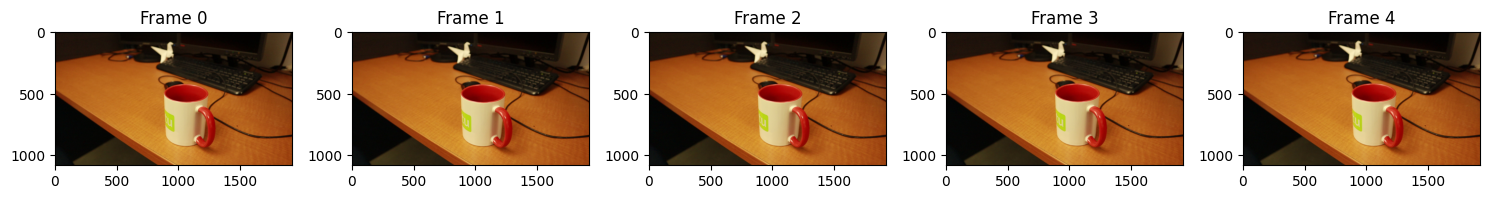

In [ ]:
# Afficher les 5 premières frames
plt.figure(figsize=(15, 5))
for i in range(5):
    path = os.path.join(FRAMES_DIR, f'frame{i}.jpg')
    if os.path.exists(path):
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f'Frame {i}')
plt.tight_layout()
plt.show()

## 4. Classe de suivi

In [ ]:
class Track:
    def __init__(self, track_id, bbox):
        self.id = track_id
        self.bbox = bbox  # [x1, y1, x2, y2]
        self.age = 0
    
    def update(self, new_bbox):
        self.bbox = new_bbox
        self.age = 0
    
    def predict(self):
        self.age += 1

## 5. Initialisation du modèle

In [ ]:
# Charger le modèle YOLOv8
model = YOLO('yolo11n.pt')

# Vérifier la classe 'cup'
class_id = None
for k, v in model.names.items():
    if v == CLASS_NAME:
        class_id = k
        break
        
if class_id is None:
    raise ValueError(f"Classe '{CLASS_NAME}' non trouvée dans le modèle")

100%|██████████| 5.35M/5.35M [00:00<00:00, 18.8MB/s]


## 6. Traitement principal

In [ ]:
# Initialiser les tracks
tracks = []
with open(INIT_FILE, 'r') as f:
    for line in f:
        parts = list(map(int, line.strip().split()))
        tracks.append(Track(parts[1], [parts[2], parts[3], parts[2]+parts[4], parts[3]+parts[5]]))

# Lister toutes les frames disponibles 
frame_files = sorted([f for f in os.listdir(FRAMES_DIR) if f.lower().startswith('frame') and f.lower().endswith('.jpg')],key=lambda x: int(x[5:-4].lstrip('0') or 0))

# Journal des résultats
# Journal des résultats
with open(OUTPUT_FILE, 'w') as results_file:
    for frame_num, frame_file in enumerate(frame_files):
        # Charger l'image
        img = cv2.imread(os.path.join(FRAMES_DIR, frame_file))
        
        # Détection YOLOv8
        detections = []
        if frame_num > 0:
            # Utiliser un seuil de confiance à 0.5 et filtrer par classe cup
            results = model.predict(img, conf=0.5, classes=[class_id], verbose=False)
            # Parcourir les détections en récupérant les scores
            for box, conf in zip(results[0].boxes.xyxy.cpu().numpy(), results[0].boxes.conf.cpu().numpy()):
                # Conversion des coordonnées en entiers
                x1, y1, x2, y2 = map(int, box)
                # Filtrage géométrique optionnel : on conserve les détections dont le ratio largeur/hauteur est raisonnable pour une tasse
                width = x2 - x1
                height = y2 - y1
                if height > 0:
                    ratio = width / height
                    # On garde uniquement les détections avec un ratio entre 0.5 et 2.0
                    if ratio < 0.8 or ratio > 2.0:
                        continue
                detections.append([x1, y1, x2, y2])
        
        # Matrice IoU
        iou_matrix = np.zeros((len(tracks), len(detections)))
        for t, track in enumerate(tracks):
            for d, det in enumerate(detections):
                a = track.bbox
                b = det
                inter = max(0, min(a[2], b[2]) - max(a[0], b[0])) * max(0, min(a[3], b[3]) - max(a[1], b[1]))
                union = (a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
                iou_matrix[t, d] = inter / union if union > 0 else 0
        
        # Association des détections
        row, col = linear_sum_assignment(-iou_matrix)
        matched = set()
        
        # Mise à jour des tracks
        for t, d in zip(row, col):
            if iou_matrix[t, d] >= IOU_THRESHOLD:
                tracks[t].update(detections[d])
                matched.add(d)
        
        # Nouveaux tracks
        for d in range(len(detections)):
            if d not in matched and frame_num > 0:
                new_id = max(t.id for t in tracks) + 1 if tracks else 1
                tracks.append(Track(new_id, detections[d]))
        
        # Vieillissement des tracks
        for track in tracks:
            track.predict()
        tracks = [t for t in tracks if t.age <= MAX_AGE]
        
        # Écrire les résultats
        for track in tracks:
            x1, y1, x2, y2 = track.bbox
            results_file.write(f"{frame_num} {track.id} {x1} {y1} {x2-x1} {y2-y1}\n")
        
        # Afficher le progrès
        if frame_num % 50 == 0:
            print(f"Traitement: {frame_num}/{len(frame_files)} frames")

Traitement: 0/1385 frames
Traitement: 50/1385 frames
Traitement: 100/1385 frames
Traitement: 150/1385 frames
Traitement: 200/1385 frames
Traitement: 250/1385 frames
Traitement: 300/1385 frames
Traitement: 350/1385 frames
Traitement: 400/1385 frames
Traitement: 450/1385 frames
Traitement: 500/1385 frames
Traitement: 550/1385 frames
Traitement: 600/1385 frames
Traitement: 650/1385 frames
Traitement: 700/1385 frames
Traitement: 750/1385 frames
Traitement: 800/1385 frames
Traitement: 850/1385 frames
Traitement: 900/1385 frames
Traitement: 950/1385 frames
Traitement: 1000/1385 frames
Traitement: 1050/1385 frames
Traitement: 1100/1385 frames
Traitement: 1150/1385 frames
Traitement: 1200/1385 frames
Traitement: 1250/1385 frames
Traitement: 1300/1385 frames
Traitement: 1350/1385 frames


## 7. Visualisation des résultats

In [ ]:
output_video = 'result_video.avi'
fps = 20  # adjust fps as needed

# Read the tracking results from results.txt
# Each line format: frame_num track_id x y width height
tracking_results = {}
with open(OUTPUT_FILE, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 6:
            continue
        frame_num = int(parts[0])
        track_id = int(parts[1])
        x = int(parts[2])
        y = int(parts[3])
        w = int(parts[4])
        h = int(parts[5])
        tracking_results.setdefault(frame_num, []).append((track_id, x, y, w, h))

# Get the sorted list of frame files
frame_files = sorted(
    [f for f in os.listdir(FRAMES_DIR) if f.lower().startswith('frame') and f.lower().endswith('.jpg')],
    key=lambda x: int(x[5:-4].lstrip('0') or 0)
)

if not frame_files:
    raise ValueError("No frame images found in the directory.")

# Get frame dimensions from the first frame
first_frame = cv2.imread(os.path.join(FRAMES_DIR, frame_files[0]))
height, width, _ = first_frame.shape

# Initialize the video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Process each frame, overlay tracking results, and write to the video
for i, frame_file in enumerate(frame_files):
    frame = cv2.imread(os.path.join(FRAMES_DIR, frame_file))
    
    # Draw tracking boxes if available for the current frame
    if i in tracking_results:
        for (track_id, x, y, w, h) in tracking_results[i]:
            # Draw the rectangle and label
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, f"ID {track_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 255, 0), 2)
    
    video_writer.write(frame)

video_writer.release()
print("Video saved as", output_video)

Video saved as result_video.avi
